In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pdb

In [3]:
from neurosim.models.ssr import StateSpaceRealization as SSR
from neurosim.utils.symbols import gen_hankel, gen_hankel_from_blocks, gen_toeplitz_from_blocks, convert_symbol
from dca.cov_util import calc_pi_from_cross_cov_mats, calc_cov_from_cross_cov_mats

In [4]:

# Question #1 about phase function: Does the Formula we have in mind give the sum of the canonical correlation 
# coefficients?

In [26]:
size = 10
A = 1/(np.sqrt(20)) * np.random.normal(size=(size, size))
B = np.eye(size)
C = scipy.stats.ortho_group.rvs(size)[:, 0:2].T

In [27]:
ssr = SSR(A=A, B=B, C=C)

In [43]:
_, Pk, Qk = ssr.pi(6, return_cov=True)

In [9]:
# Step 2: Does the phase hankel operator correspond to a suitably normalized hankel/topelitz matrix?

In [36]:
H_ = gen_hankel_from_blocks(ssr.autocorrelation(12))
Tm, Tp = gen_toeplitz_from_blocks(ssr.autocorrelation(6))

In [37]:
Lm = np.linalg.cholesky(Tm)
Lp = np.linalg.cholesky(Tp)

In [38]:
# see equation 12.116 

In [39]:
S

array([0.44433774, 0.2966348 , 0.23304629, 0.03523016, 0.00814261,
       0.00132618])

In [40]:
_, S, _ = np.linalg.svd(np.linalg.inv(Lp) @ H_ @ np.linalg.inv(Lm).T)

In [41]:
np.sum(S**2)

0.3657173059020021

In [44]:
np.trace(Pk @ Qk)

0.36571730590200174

In [ ]:
# Question 2: Does the causal realization of the phase function match the coefficients obtained from 
# convert_symbol?

In [17]:
thetak = convert_symbol(ssr.phase_function, 100)

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/numpy/fft/_pocketfft.py:73: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


In [18]:
thetak_ = ssr.causal_phase_function(100)

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


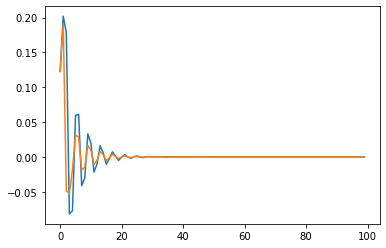

In [19]:
plt.plot(thetak_[:, 0, 1])
plt.plot(thetak[:, 0, 1])

In [ ]:
# Don't quite match up, but can we match the normalized Hankel matrix to the that generated by either one of
# these realizations?

In [20]:
Htheta = gen_hankel_from_blocks(ssr.causal_phase_function(100))

In [21]:
HthetaT = gen_hankel_from_blocks(np.transpose(ssr.causal_phase_function(100), axes=(0, 2, 1)))

In [22]:
np.trace(Htheta @ HthetaT)

0.7954067077980872

In [47]:
thetak = ssr.causal_phase_function(12)
thetastark =  np.transpose(ssr.causal_phase_function(12), axes=(0, 2, 1)) 

In [48]:
np.trace(sum([k * thetak[k, ...] @ thetastark[k, ...] for k in range(1, len(thetak))]))

0.36531062311476326

In [ ]:
# Verify calculation of MGF of Hankel trace

In [25]:
u, s, vh = np.linalg.svd(ssr.Bmin @ ssr.Bmin.T)

In [33]:
np.allclose(A, sum([e[i] * np.outer(r[:, i], l[:, i]) for i in range(e.size)]))

False

In [27]:
e, r, l = scipy.linalg.eig(A, left=True)

In [566]:
sqrt_factor = scipy.linalg.sqrtm(np.eye(Bmin.shape[1]) - Bmin.T @ np.linalg.inv(ssr.Pmin) @ Bmin)
Bmax = - np.linalg.inv(ssr.Pmin) @ np.linalg.inv(ssr.A) @ Bmin @ sqrt_factor

In [34]:
# Can one obtain the phase function from the polar decomposition of the minimum phase transfer functions?

In [35]:
z = np.exp(1j * 0.25)

In [36]:
ssr.phase_function(z)

array([[ 0.92975275-0.00643528j,  0.33248738-0.15802073j],
       [-0.32848761-0.16617551j,  0.92931099+0.02937148j]])

In [48]:
U1, S1 = scipy.linalg.polar(ssr.minphase_transfer_fn(z), side='left')

In [49]:
U2, S2 = scipy.linalg.polar(ssr.maxphase_acausal_transfer_fn(z), side='left')

In [50]:
np.conjugate(U2).T @ U1

array([[ 0.92975275-0.00643528j,  0.33248738-0.15802073j],
       [-0.32848761-0.16617551j,  0.92931099+0.02937148j]])

In [58]:
from scipy.stats import unitary_group, ortho_group
from dca.dca import DynamicalComponentsAnalysis as DCA
from tqdm import tqdm

In [56]:
np.linalg.det(ssr.phase_function(z))

(0.9996956157918032+0.02467124895168254j)

In [68]:
size = 10
z = np.exp(1j * np.linspace(0, 2 * np.pi, 100))
reps = 50

wminus = []
wplus = []
bminus = []
bplus = []

for rep in tqdm(range(reps)):

    wminus.append([])
    wplus.append([])
    bminus.append([])
    bplus.append([])

    A = 1/(np.sqrt(20)) * np.random.normal(size=(size, size))
    while max(np.abs(np.linalg.eigvals(A)) > 0.99):
        A = 1/(np.sqrt(20)) * np.random.normal(size=(size, size))

    ssr = SSR(A = A, B=np.eye(A.shape[0]), C = np.eye(A.shape[0]))
    dcamodel = DCA(d = 1, T = 5)
    x = ssr.trajectory(T=10000, burnoff=True)
    dcamodel.estimate_data_statistics(x)
    n_init = 10

    for i in range(n_init):
        V_opt, _ = dcamodel._fit_projection(record_V=True)

        wminus_ = np.zeros((z.size, len(dcamodel.V_seq) + 1)).astype(np.complex)
        wplus_ = np.zeros((z.size, len(dcamodel.V_seq) + 1)).astype(np.complex)
        bminus_ = np.zeros((len(dcamodel.V_seq) + 1, size))
        bplus_ = np.zeros((len(dcamodel.V_seq) + 1, size))

        for j in range(len(dcamodel.V_seq)):

            ssr_opt = SSR(A = A, B = np.eye(A.shape[0]), C = dcamodel.V_seq[j].T)
            ssr_opt.solve_min_phase()
            ssr_opt.solve_max_phase()

            bminus_[j] = np.squeeze(ssr_opt.Bmin)
            bplus_[j] = np.squeeze(ssr_opt.Bmax)

            wminus_[:, j] = np.squeeze(ssr_opt.minphase_transfer_fn(z))
            wplus_[:, j] = np.squeeze(ssr_opt.maxphase_acausal_transfer_fn(z))

        ssr_opt = SSR(A = A, B = np.eye(A.shape[0]), C = V_opt.T)
        ssr_opt.solve_min_phase()
        ssr_opt.solve_max_phase()

        bminus_[-1] = np.squeeze(ssr_opt.Bmin)
        bplus_[-1] = np.squeeze(ssr_opt.Bmax)

        wminus_[:, -1] = np.squeeze(ssr_opt.minphase_transfer_fn(z))
        wplus_[:, -1] = np.squeeze(ssr_opt.maxphase_acausal_transfer_fn(z))
        

        wminus[rep].append(wminus_)
        wplus[rep].append(wplus_)
        bminus[rep].append(bminus_)
        bplus[rep].append(bplus_)

  0%|          | 0/50 [00:00<?, ?it/s]/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 50/50 [

In [ ]:
ssr.Bmin

In [163]:
min_max_angle

array([1.39655465, 0.56678958])

(array([ 2.,  0.,  2.,  4.,  9.,  2., 10., 11.,  7.,  3.]),
 array([0.79307461, 0.82040117, 0.84772772, 0.87505428, 0.90238083,
        0.92970739, 0.95703394, 0.9843605 , 1.01168706, 1.03901361,
        1.06634017]),
 <BarContainer object of 10 artists>)

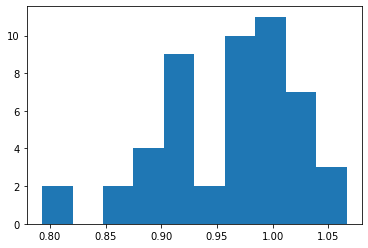

In [164]:
plt.hist(min_max_angle_rand % np.pi/2)

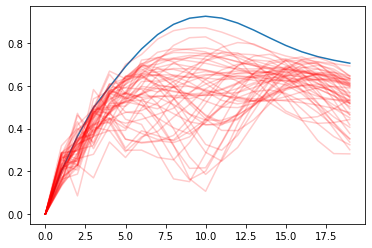

In [165]:
plt.plot([k * np.linalg.norm(theta_k[k]) for k in range(len(theta_k))])

for i in range(reps):
    plt.plot([k * np.linalg.norm(thetak_rand[i, k, ...]) for k in range(20)], 'r', alpha=0.2)

In [77]:
A = np.diag(np.random.uniform(0, 1, size=10))
#C = scipy.stats.ortho_group.rvs(10)[:, 0:2].T
C = np.zeros((2, 10))
C[0, 3] = 1
C[0, 6] = 1
ssr = SSR(A = A, B=np.eye(A.shape[0]), C = C)

In [78]:
ssr.solve_min_phase()
ssr.solve_max_phase()

In [51]:
ssr.Bmin

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [1.33518466e-01, 6.82077636e-18],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [7.20193888e-01, 3.67910266e-17],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00]])

In [52]:
ssr.Bmax

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [5.82531397e-01, 2.97585532e-17],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [2.95786259e-01, 1.51102089e-17],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00]])

In [57]:
ssr.Pmin[ssr.Pmin > 0]

array([9.28355728e-45, 1.26048008e-13, 2.54878605e-19, 1.87190978e-02,
       1.16983829e-01, 5.84815114e-73, 1.29079314e-03, 1.16983829e-01,
       1.54859648e+00, 5.67859425e-12, 1.10331689e-62, 3.26531045e-04])

In [88]:
np.trace(ssr.Bmin.T @ ssr.P @ ssr.Bmin)

0.9556239810473752

In [89]:
np.trace(ssr.Pmin)

41.87774886320812

In [80]:
np.linalg.eigvals(ssr.Pmin)

array([1.80470730e-02, 9.37576916e-01, 1.90355008e-04, 3.93988675e-13,
       3.41809553e-03, 3.60993934e-05, 4.09184172e+01, 5.81877862e-14,
       1.86286280e-23, 6.31250741e-05])

In [90]:
np.diag(ssr.P)

array([ 2.63685447,  1.30983451,  3.42338075,  2.27309467,  2.35038121,
       57.95588842,  1.35078248,  1.27431896,  1.07846477,  2.43749725])

In [86]:
np.diag(ssr.Pmin)

array([1.90355008e-04, 3.93988675e-13, 3.41809553e-03, 8.16534780e-01,
       3.60993934e-05, 4.09184172e+01, 1.39089209e-01, 5.81877862e-14,
       1.86286280e-23, 6.31250741e-05])

In [81]:
np.linalg.eigvals(ssr.P - ssr.Pmin)

array([ 1.        ,  1.66825316,  2.63666411,  1.30983451,  3.41996266,
        2.35034511, 17.03747123,  1.27431896,  1.07846477,  2.43743413])

In [21]:
np.linalg.eigvals(ssr.Pmin)

array([1.33255221e+00, 1.06007140e+00, 1.16475364e-01, 3.20168921e-02,
       6.93548382e-03, 2.67070212e-03, 5.95617049e-05, 9.15638238e-06,
       6.37780196e-06, 2.23183103e-06])

In [23]:
np.linalg.eigvals(ssr.Pmax)

array([5.93341361e-01, 5.37985249e-01, 3.78290200e-02, 3.18121165e-02,
       3.30977946e-03, 1.05360280e-03, 1.90525039e-04, 4.10019626e-05,
       7.33430352e-07, 2.56825861e-08])

In [58]:
np.allclose(ssr.Pmin @ ssr.Pmax, ssr.Pmax @ ssr.Pmin)

False

In [61]:
eigvals, U = np.linalg.eig(ssr.Pmin)

In [62]:
L = np.diag(eigvals)

In [63]:
R = U @ scipy.linalg.sqrtm(L)

In [67]:
np.trace(R.T @ ssr.Pmax @ R)

0.4602283633095998

In [66]:
np.trace(ssr.Pmin @ ssr.Pmax)

0.4602283633095999

In [74]:
l1 = 0.52
l2 = 0.98

In [71]:
f1 = lambda l1, l2: -1*np.log(1 - l1) - np.log(1 - l2)
f2 = lambda l1, l2 : l1 + l2

In [76]:
f1(l1, l2)

4.645992180508346

In [75]:
f2(l1, l2)

1.5